#<center> Universidad Sergio Arboleda
##<center> Inteligencia Artificial
##<center> Parcial II
###<center> Presentado por: Diago Bermúdez, Julián Cárdenas, Daniel Velásquez y Miguel Salazar

### Importación de Bibliotecas y Herramientas Computacionales

In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import SGDRegressor
from statsmodels.api import qqplot
from itertools import combinations
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_squared_error as mse 

# A. Preparación de los datos:

### Carga de los datos en un **DataFrame**

In [288]:
path = 'https://raw.githubusercontent.com/jpospinalo/MachineLearning/main/Linear%20Regression/housing2.csv'

In [289]:
df = pd.read_csv(path)

### Visualización de una muestra del DataFrame

In [290]:
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,"$215000,0"
1,5,6,882.0,Y,896,"$105000,0"
2,6,6,1329.0,Y,1329,"$172000,0"
3,7,5,2110.0,Y,2110,"$244000,0"
4,5,5,928.0,Y,1629,"$189900,0"


### Asignación de nuevos nombres a las columnas

In [291]:
df.columns

Index(['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area', 'SalePrice'],
      dtype='object')

In [292]:
df = df.rename(columns={'Overall Qual':'Quality', 'Overall Cond':'Condition', 'Total Bsmt SF':'Basement_sqft', 'Central Air':'Central_air',
       'Gr Liv Area':'Livable_area', 'SalePrice':'Sale_price'})

### Generar un resumen de los datos a través del método `info()`

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Quality        2930 non-null   int64  
 1   Condition      2930 non-null   int64  
 2   Basement_sqft  2929 non-null   float64
 3   Central_air    2930 non-null   object 
 4   Livable_area   2930 non-null   int64  
 5   Sale_price     2930 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 137.5+ KB


No todos los tipos de columnas son correctos pues, las columnas `Central Air` y `SalePrice` son de tipo `object`. Estas columnas requieren ser tratadas y convertir el tipo de dato.

Se presenta una diferencia en la cantidad de datos no nulos de las columnas, mas exactamente en la columna Total Bsmt SF donde tiene menor esta cantidad con respecto a las demás columnas. Esto puede ser analizado con mas detalle mas adelante cuando observemos la presencia de datos nulos en el dataframe

### Corrección del tipo de dato de `Sale_price`, ya que aparece como string y resulta mejor reemplazarlo por float

In [294]:
df['Sale_price'] = df['Sale_price'].apply(lambda x: float(x.replace('$','').replace(',','.')))

### Qué tratamiento le daría a la característica `Central Air`?

- Al ser un dato no numérico, el mejor tratamiento que se le puede dar es tratarlo como un dato categórico y transformarlo a numérico mediante un `encoder`.

In [295]:
encoder = OrdinalEncoder()
encoder.fit(df[['Central_air']])

OrdinalEncoder()

In [296]:
df['Central_air'] = encoder.transform(df[['Central_air']])

Tras realizar los cambios respectivos de datos, se puede comprobar que las columnas `Central Air` y `SalePrice` cambiaron su tipo de dato de object a `float`

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Quality        2930 non-null   int64  
 1   Condition      2930 non-null   int64  
 2   Basement_sqft  2929 non-null   float64
 3   Central_air    2930 non-null   float64
 4   Livable_area   2930 non-null   int64  
 5   Sale_price     2930 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 137.5 KB


### Generación de un conjunto de datos de prueba con el 20% de los datos disponibles.

- Se implementa la función train_test_split de sklearn

- Se separan los datos en dos grupos, 20% para test y el 80% restante para entrenamiento.

- Shuffle se usa para mezclar los datos antes de separar los datos.


In [298]:
train, test = train_test_split(df, test_size=0.2, random_state=3, shuffle=True)

### Verifique si existen valores faltantes. En caso de existir determine cual es la mejor estrategia a utilizar. Consulte las opciones de la clase SimpleImputer() disponible en Sklearn.

Revisión de datos nulos o faltantes

In [299]:
train.isnull().sum()

Quality          0
Condition        0
Basement_sqft    1
Central_air      0
Livable_area     0
Sale_price       0
dtype: int64

Se presenta un único dato null en la columna Total Bsmt SF

En caso tal de que existan valores faltantes, se implementa la clase `SimpleImputer` de Sklearn. Se va a usar la opcion de ```strategy=median```, para reemplazar los valores faltantes por la media de la columna



Revisión de media y mediana de la columna con datos faltantes.

In [300]:
train['Basement_sqft'].mean()

1053.9965855740504

In [301]:
train['Basement_sqft'].median()

991.0

Dado que la media y la mediana en la columna de datos faltantes tiene una distancia considerable, resulta conveniente imputar los datos con una instancia de `SimpleImputer()` con estrategia `median`.

### Construya un pipeline que incluya los pasos de imputación de valores faltantes y el proceso de escalado

In [302]:
imputer_mediana = SimpleImputer(strategy='median')
std_scaler = StandardScaler()


Creación de Pipeline para datos numéricos

In [303]:
pipeline = Pipeline(
    [
        ('Paso 1: Imputación con Mediana', imputer_mediana),
        ('Paso 2: Escalado con StdDev', std_scaler)
    ]
)

Transformación de los datos de entrenamiento

In [304]:
train.columns

Index(['Quality', 'Condition', 'Basement_sqft', 'Central_air', 'Livable_area',
       'Sale_price'],
      dtype='object')

Se cambian las escalas de los datos de las columnas `Overall Qual`, `Overall Cond`, `Total Bsmt SF`, `Central Air`, y `Gr Liv Area`

In [305]:
transformed_train = pipeline.fit_transform(train[['Quality', 'Condition', 
                                                  'Basement_sqft', 'Central_air',
                                                  'Livable_area']])

In [306]:
transformed_train = pd.DataFrame(transformed_train, columns=['Quality','Condition','Basement_sqft', 'Central_air', 'Livable_area'], index=train.index)

- Se agrega `Sale_price` a la varialbe `transformed_train` sin modificar, como buena práctica para la implementación de modelos de Machine Learning.
- Se chequea que la transformación de los datos se haya ejecutado correctamente.

In [307]:
transformed_train['Sale_price'] = train['Sale_price']
transformed_train.head()

,Quality,Condition,Basement_sqft,Central_air,Livable_area,Sale_price
2443,1.359084,-0.506931,-0.022319,0.268846,0.929475,286000.0
1512,-1.471385,1.259979,-0.234995,0.268846,-0.401542,108000.0
1411,-0.763768,-0.506931,-0.425284,-3.719603,-1.234401,99600.0
1374,-1.471385,-1.390386,-2.359516,0.268846,0.174454,134432.0
1790,1.359084,-0.506931,1.414922,0.268846,0.380723,307000.0


# B. Análisis Exploratorio:

### Generar un resumen estadístico utilizando el método `describe()`

In [308]:
transformed_train.describe()

,Quality,Condition,Basement_sqft,Central_air,Livable_area,Sale_price
count,2.344000e+03,2.344000e+03,2.344000e+03,2.344000e+03,2.344000e+03,2344.000000
mean,2.425061e-16,-3.395085e-16,-1.386831e-16,-1.591446e-16,-5.607952e-17,180620.603242
std,1.000213e+00,1.000213e+00,1.000213e+00,1.000213e+00,1.000213e+00,81141.534863
min,-3.594236e+00,-4.040751e+00,-2.359516e+00,-3.719603e+00,-2.265744e+00,12789.000000
25%,-7.637676e-01,-5.069312e-01,-5.780749e-01,2.688459e-01,-7.347827e-01,129000.000000
50%,-5.615050e-02,-5.069312e-01,-1.409699e-01,2.688459e-01,-1.135440e-01,160000.000000
75%,6.514666e-01,3.765237e-01,5.463092e-01,2.688459e-01,4.896949e-01,213492.500000
max,2.774318e+00,3.026888e+00,1.131890e+01,2.688459e-01,8.063261e+00,755000.000000


Se pueden observar datos de utilidad tales como el numero de datos presentes (count), el promedio de los datos (mean), la desviación estándar (std), los valores mínimos, del 20%, 50%, 70% y máximos (min, 20%, 50%, 70%, max) esto anterior dado por cada columna

### Genere el histograma de frecuencias para todas las características disponibles

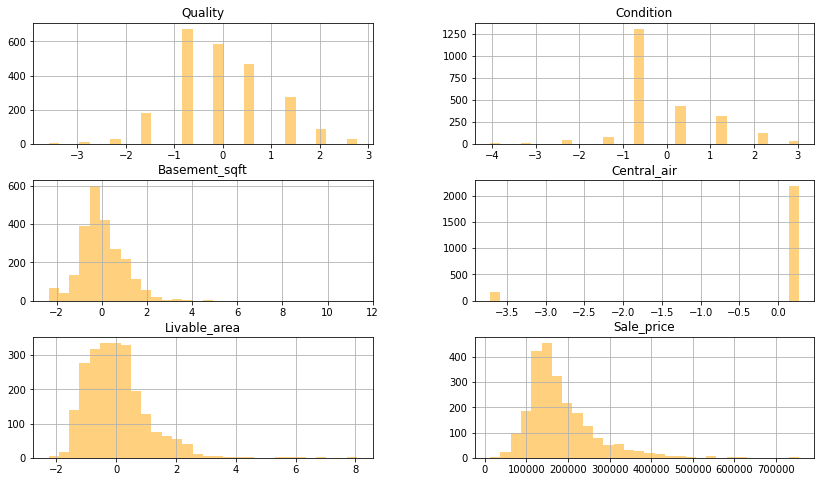

In [309]:
transformed_train.hist(bins=30, figsize=(14,8), color='orange', alpha=0.5)
plt.show()

### Identifique posibles valores atípicos en los datos. Elimine los valores utilizando el método IQR (si lo considera necesario)

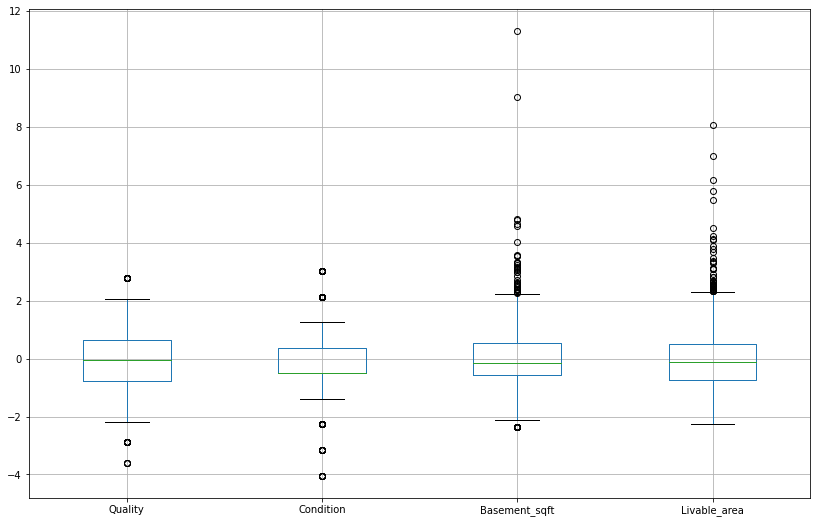

In [310]:
transformed_train[['Quality', 'Condition', 'Basement_sqft', 'Livable_area']].boxplot(figsize=(14,9))

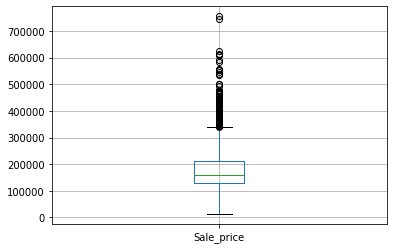

In [311]:
transformed_train[['Sale_price']].boxplot()

In [312]:
Q1 = transformed_train.quantile(0.25)
Q3 = transformed_train.quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

### Genere una matriz de dispersión para identificar correlaciones entre variables.

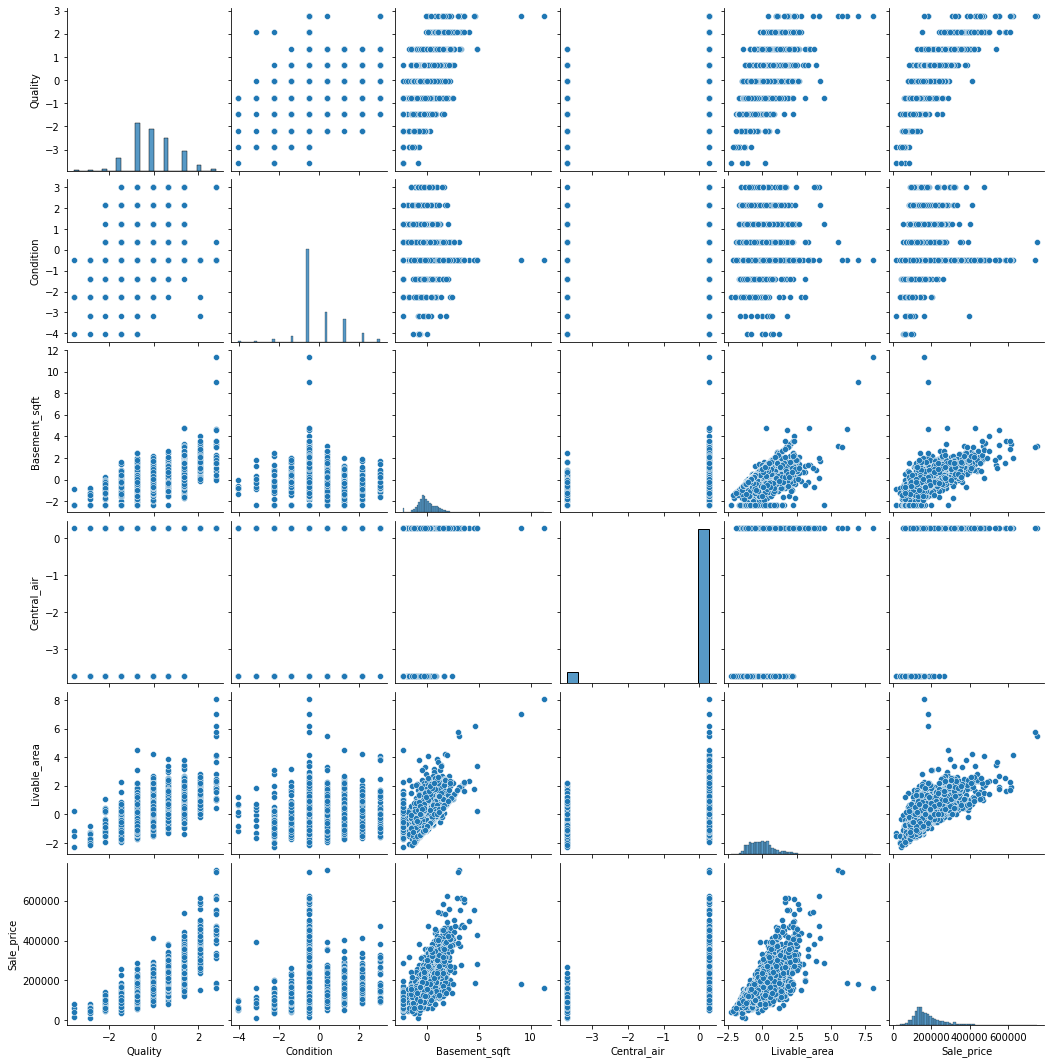

In [313]:
sns.pairplot(transformed_train)

Según lo observado en la matriz de dispersión, se puede decir que hay mayor correlación entre la superficie habitable por encima del nivel del suelo en pies cuadrados `Gr Liv Area`, el área total del sótano en pies cuadrados `Total Bsmt SF`, y la calificación en la calidad de materiales utilizados de la vivienda `Overall Qual` con respecto al precio de venta de una vivienda (SalePrice)

### Genere la matriz de correlación para todas las características y preséntela a través de un mapa de calor.

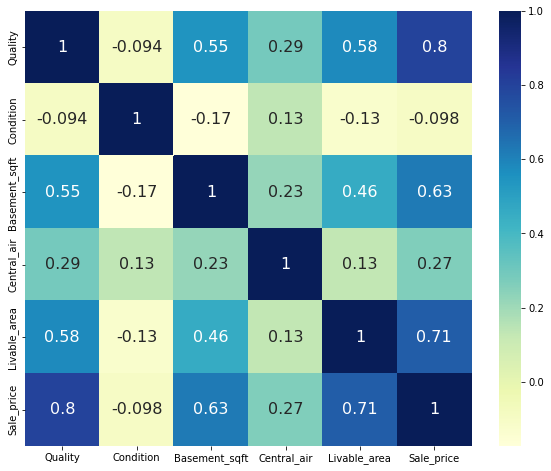

In [314]:
plt.figure(figsize=(10,8))
sns.heatmap(transformed_train.corr(), annot=True, cmap='YlGnBu', annot_kws={'size':16})

In [315]:
transformed_train.corr()

,Quality,Condition,Basement_sqft,Central_air,Livable_area,Sale_price
Quality,1.000000,-0.094340,0.549307,0.292027,0.581351,0.798626
Condition,-0.094340,1.000000,-0.173024,0.134783,-0.125590,-0.097876
Basement_sqft,0.549307,-0.173024,1.000000,0.225090,0.458731,0.625227
Central_air,0.292027,0.134783,0.225090,1.000000,0.130098,0.265158
Livable_area,0.581351,-0.125590,0.458731,0.130098,1.000000,0.708178
Sale_price,0.798626,-0.097876,0.625227,0.265158,0.708178,1.000000


### Considerando los valores de correlación determine cuales variables podrían tener una mayor influencia sobre el modelo.

In [316]:
transformed_train.corr()['Sale_price'].sort_values(ascending=False)

Sale_price       1.000000
Quality          0.798626
Livable_area     0.708178
Basement_sqft    0.625227
Central_air      0.265158
Condition       -0.097876
Name: Sale_price, dtype: float64

Al hacer una revisión de la correlación entre las distintas variables y `Sale_price`. Resulta que las variables que mayor relación tienen con este indicador son `Quality`, `Central Air` y `Basement_sqft`, cada una con su correspondiente correlación positiva de 0.79, 0.70 y 0.62

# C. Generar el Modelo

Separación de los conjuntos `x` y `y` de entrenamiento.

In [317]:
model_result = {}
X_train, y_train = train.drop('Sale_price', axis='columns'), transformed_train['Sale_price']

Se crea un nuevo pipeline numérico, al que se le adiciona una instancia de Regresión Lineal a partir del Gradiente Descendente o `SGDRegressor()`

In [318]:
for feature in X_train.columns:
  
  regressorSGD = Pipeline(
      steps=[("numerical_imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler()), 
           ("sgd", SGDRegressor())])
  
  regressorSGD.fit(X_train[feature].values.reshape(-1,1), y_train)

  model_result[feature] = regressorSGD

Se itera sobre las variables de entrenamiento para determinar la linea que se ajusta al comportamiento de las mismas.

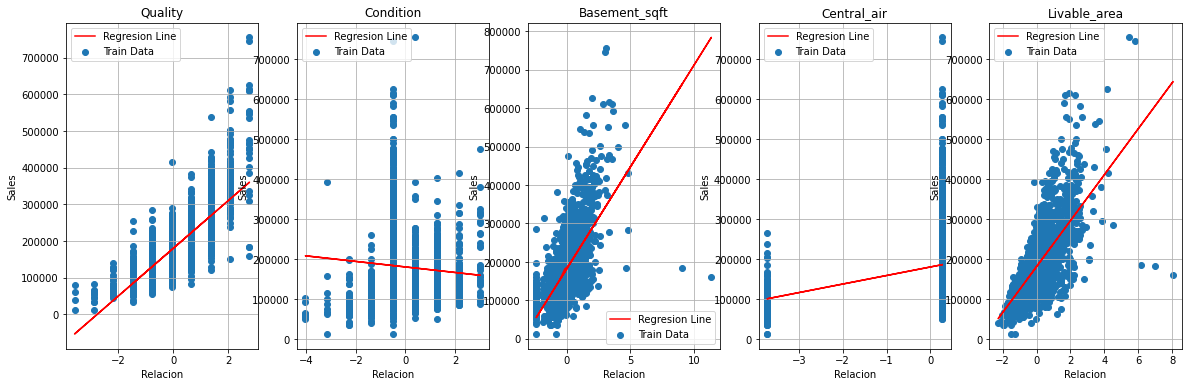

In [319]:
fig, axes = plt.subplots(1, len(X_train.columns), figsize=(20, 6))

for i in range(5):
  X_values = X_train.iloc[:,i].values.reshape(-1, 1)
  y_values = y_train.values.reshape(-1, 1)

  axes[i].scatter(transformed_train.iloc[:,i], y_values, label='Train Data')
  model = model_result[X_train.columns[i]]
  predicted = model.predict(X_values)

  axes[i].plot(transformed_train.iloc[:,i], predicted, color='red', label='Regresion Line')
  axes[i].set_title(X_train.columns[i])
  axes[i].set_xlabel('Relacion')
  axes[i].set_ylabel('Sales')
  axes[i].grid()
  axes[i].legend()

Teniendo en cuenta la información obtenida a partir de la matriz de correlaciones, se seleccionan las variables que mayor tienen correlación con la variable a predecir, que es el precio de las viviendas. 

A partir de las mismas, se efectúa su respectivo histograma y gráfico de residuos.

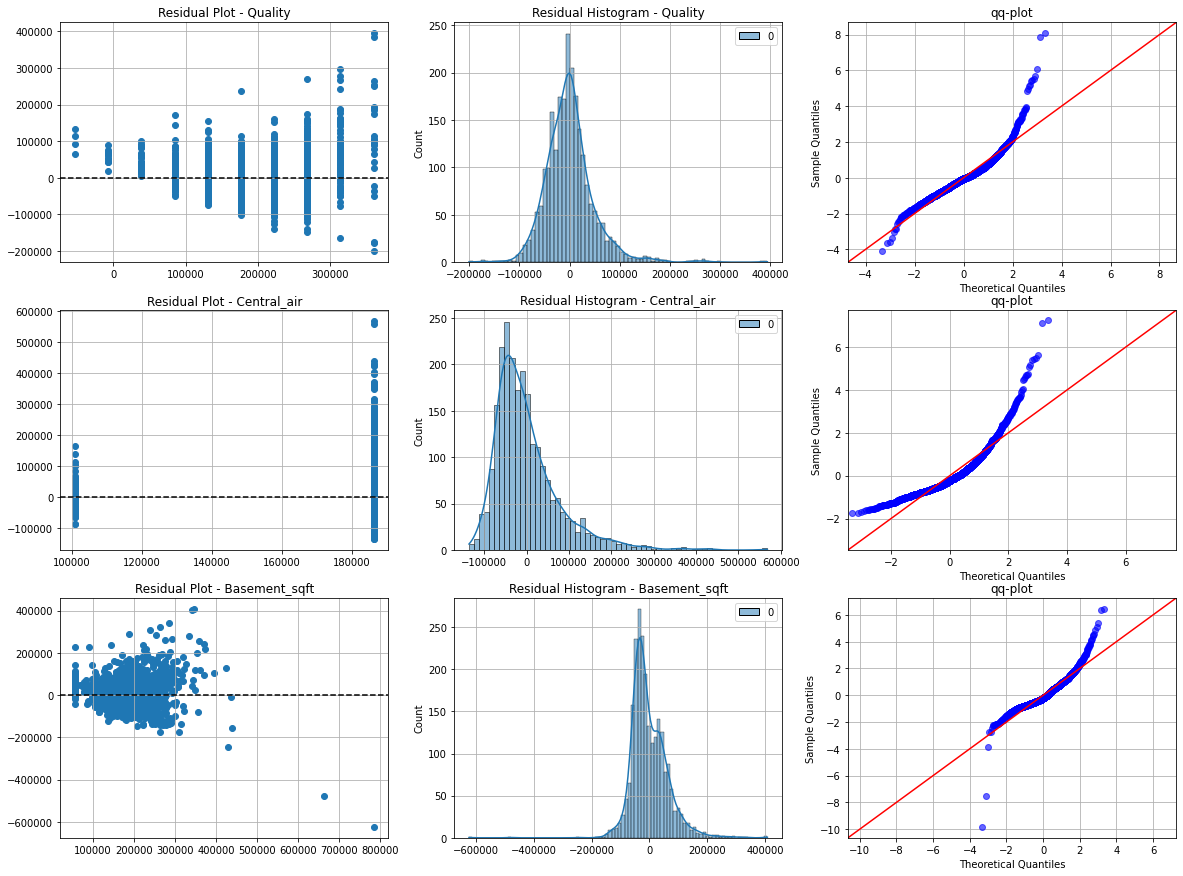

In [320]:
selected = ['Quality', 'Central_air','Basement_sqft']
residuals_train = {}
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for i, feature in enumerate(selected):

  X_values = X_train[feature].values.reshape(-1,1)
  y_values = y_train.values.reshape(-1, 1)
  model = model_result[feature]
  y_pred = model.predict(X_values)
  residual =  y_values - y_pred.reshape(-1,1) 
  residuals_train[feature] = residual
  axes[i][0].axhline(y=0, color='black', linestyle='--') 
  axes[i][0].scatter(y_pred, residual)
  axes[i][0].set_title('Residual Plot - ' +  feature)
  sns.histplot(residual, kde=True, ax=axes[i][1])
  axes[i][1].set_title('Residual Histogram - ' +  feature)
  qqplot(np.sort(residual.flatten()), fit=True, line="45", ax=axes[i][2], alpha= 0.6)
  axes[i][2].set_title('qq-plot')
  axes[i][0].grid()
  axes[i][1].grid()
  axes[i][2].grid()

A partir de la información obtenida, es posible evidenciar lo siguiente:

- No hay sesgo aparente en el gráfico de residuos que evidencie un comportamiento anormal en los mismos.
- El histograma de residuos muestra un comportamiento gaussiano en todas las variables.
- El qqplot muestra colas pesadas en ambos lados de los gráficos.

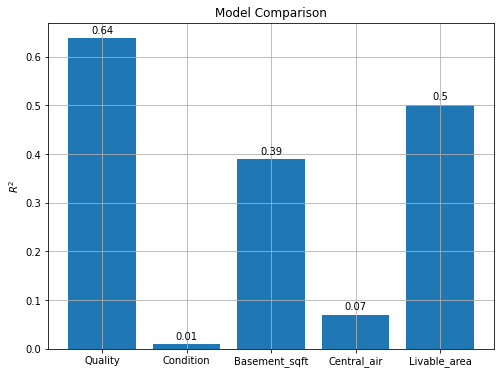

In [321]:
scores = []
for i, feature in enumerate(X_train.columns):
  X_values = X_train.iloc[:,i].values.reshape(-1, 1)
  y_values = y_train.values.reshape(-1, 1)
  model = model_result[feature]
  scores.append(model.score(X_values, y_values))

plt.figure(figsize=(8,6))
plt.bar(X_train.columns, scores)
plt.ylabel('$R^2$')
plt.title('Model Comparison')
plt.grid()

def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.01, round(y[i],2), ha = 'center')

add_labels(X_train.columns, scores)

- Recordemos que el  coeficiente de determinación está dado por una valoración entre 0 y 1. Donde se considera como el porcentaje de efectividad del modelo, por ejemplo, un valor de 0.8 implicaría el 80% de efectividad.

- Se determina que el modelo con mayor coeficiente de determinación es el de `Qualuty` con un puntaje de 0.64, es decir, de 64% de efectividad

- El orden de coeficientes más altos son; `Quality` (64%), `Livable_Area` (50%), `Basement_sqft` (39%), `Central_air` (7%) y 'Overall Cond' (1%)

Estas medidas son aquellas que miden la distancia entre una línea ajustada y todos los puntos de datos que están dispersos en el diagrama



Por lo tanto, mediante la medida `R2`, es posible evidenciar que las variables `Quality`, `Livable_area` y `Basement_sqft` son aquellas que tienen valores más cercanos a 1. Por consiguiente, se puede concluir que efectivamente el mapa de calor de correlaciones resaltaba las variables indicadas.

### Construya un modelo para cada una de las posibles combinaciones de características. 

- Con base en los análisis anteriores, se decidió tomar las variables `Quality`, `Central_air` y `Basement_sqft` como las candidatas para el estudio de combinaciones posibles.

In [322]:
all_combinatios = []
model_final = {}
features = ['Quality', 'Central_air','Basement_sqft']
final_scores = []
for i in range(1, 4):
  all_combinatios += list(combinations(features, i))

all_combinatios = [list(combination) for combination in all_combinatios]
all_combinatios

[['Quality'],
 ['Central_air'],
 ['Basement_sqft'],
 ['Quality', 'Central_air'],
 ['Quality', 'Basement_sqft'],
 ['Central_air', 'Basement_sqft'],
 ['Quality', 'Central_air', 'Basement_sqft']]

### Suponga que recibe un nuevo dataset con 100 características ¿es viable probar todas las combinaciones? ¿Cuántas modelos se generarían?

No resultaría viable probar todas las combinaciones en el caso de tener 100 características, debido a que todas sus posibles combinaciones serían demasiadas para la memoria de un sistema.

- Para el caso de 100 características, se generarían `1.2676506002282297e+30` modelos distintos, teniendo en cuenta que el número de modelos sería igual a 
<center> $\sum_{i=1}^{100} \frac{100!}{(100-i)! \cdot i!}$

In [323]:
for combination in all_combinatios:
   sgd = SGDRegressor()
   X_values = X_train[combination].values.reshape(-1, len(combination))
   y_values = y_train.ravel()
   
   regressorSGD = Pipeline(
      steps=[("numerical_imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler()), 
           ("sgd", SGDRegressor())])
  
   regressorSGD.fit(X_values, y_values)
   y_pred = regressorSGD.predict(X_values)
   model_final[combination.__repr__()] = regressorSGD
   final_scores.append(regressorSGD.score(X_values, y_values))

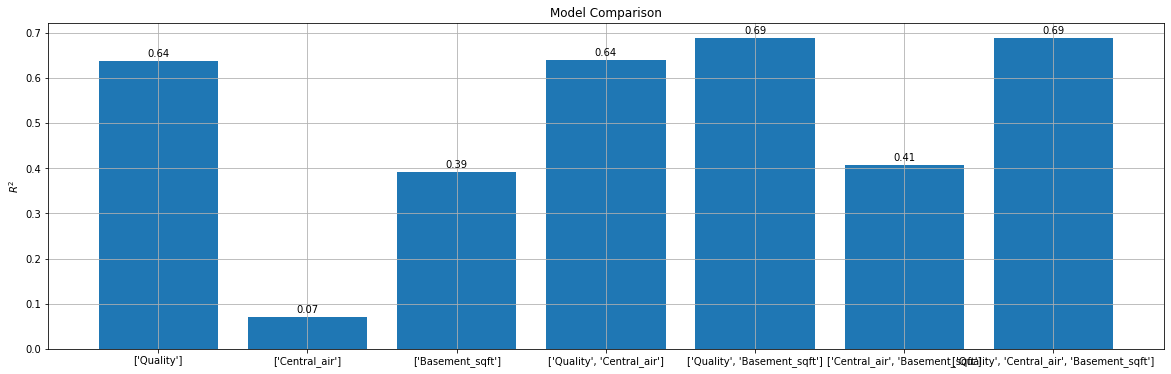

In [324]:
plt.figure(figsize=(20,6))
plt.bar(model_final.keys(), final_scores)
plt.ylabel('$R^2$')
plt.title('Model Comparison')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.01, round(y[i],2), ha = 'center')

add_labels(model_final.keys(), final_scores)  

En la gráfica anterior, se puede concluir que tanto las combinaciones de `[Quality + Central_air]` y `[Quality + Central_air + Basement_sqft]` son aquellas que mejores resultados arrojan.

# D. Evaluación de Desempeños:

### Evalúe cada modelo con los datos de prueba. Recuerde utilizar el pipeline realizar las estimaciones.

In [325]:
test_scores = []

X_test, y_test = test.drop('Sale_price', axis='columns'), test['Sale_price']

for combination in all_combinatios:

  X_values = X_test[combination].values.reshape(-1,len(combination))
  y_values = y_test.values.reshape(-1, 1)

  model = model_final[combination.__repr__()]
  test_scores.append(model.score(X_values, y_values))

### Compare los coeficientes de determinación de los datos de prueba con lo obtenidos en los datos de entrenamiento a través de un gráfico de barras

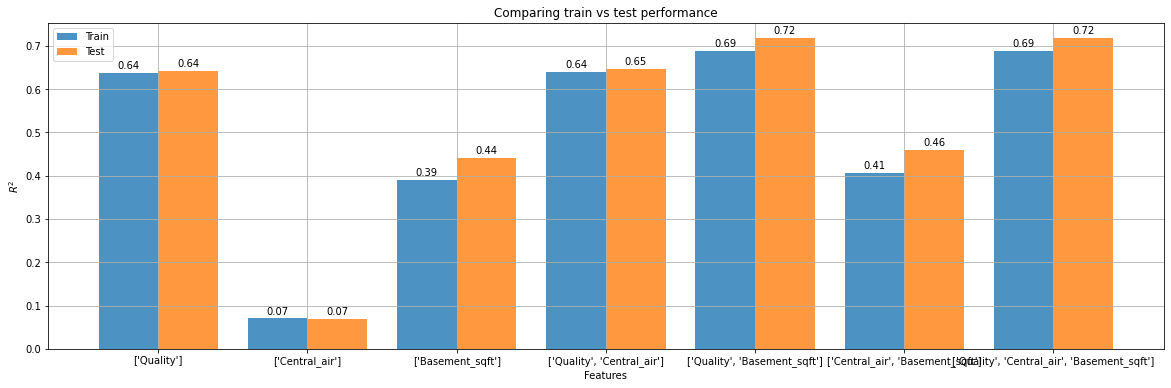

In [326]:
plt.figure(figsize=(20,6))

X_axis = np.arange(len(model_final.keys()))

plt.bar(X_axis - 0.2, final_scores, 0.4, label = 'Train', alpha=0.8)
plt.bar(X_axis + 0.2,test_scores, 0.4, label = 'Test', alpha=0.8)

plt.ylabel('$R^2$')
plt.title('Test Comparison')
plt.grid()
plt.xticks(X_axis, model_final.keys())
plt.xlabel("Features")
plt.title("Comparing train vs test performance")
plt.legend()
  
def addlabels(x, y, val):
    for i in range(len(x)):
        plt.text(i + val , y[i] + 0.01, round(y[i],2), ha = 'center')

addlabels(model_final.keys(), final_scores, - 0.2)
addlabels(model_final.keys(), test_scores, + 0.2)
plt.show()

### Realice el análisis de residuos para el conjunto de prueba. Compare los resultados obtenidos con los datos de entrenamiento.

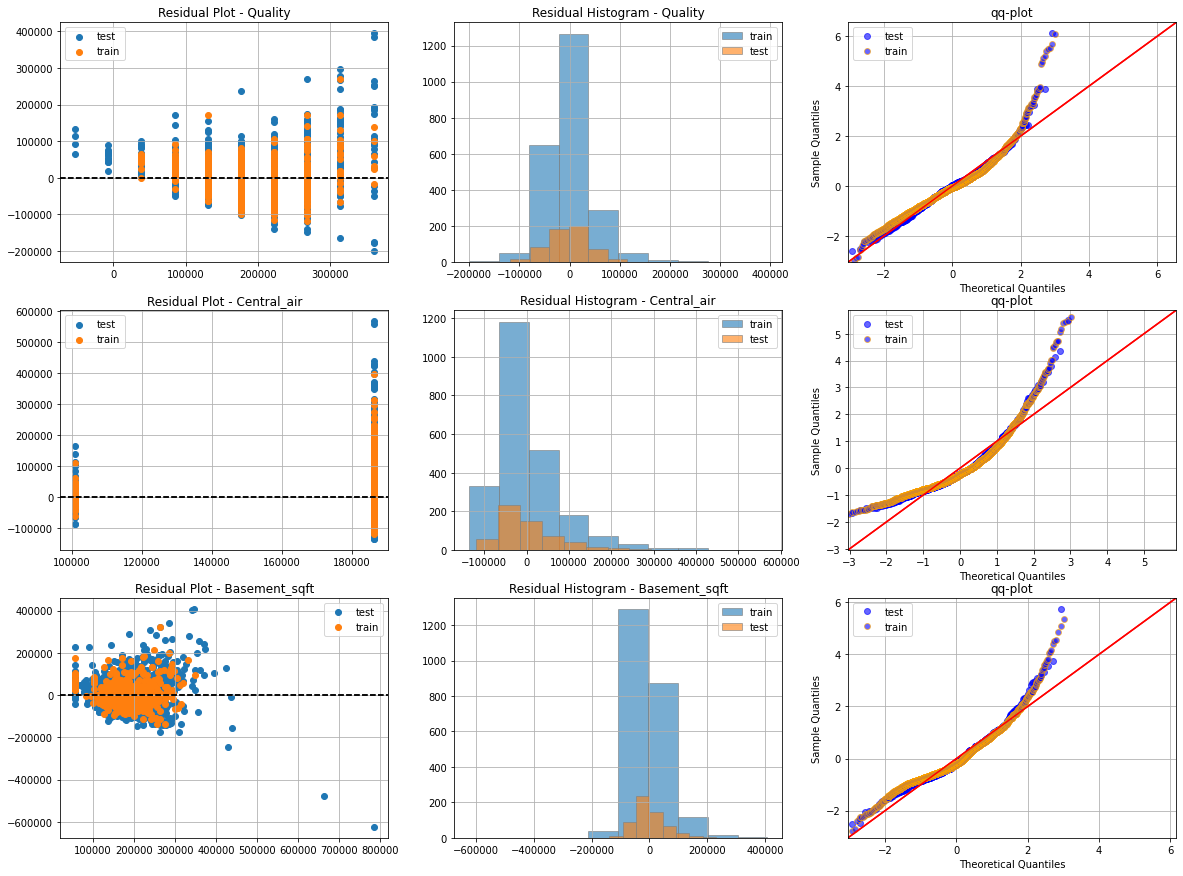

In [327]:
selected = ['Quality', 'Central_air','Basement_sqft']
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for i, combination in enumerate(selected):

  X_train_values = X_train[combination].values.reshape(-1,1)
  residual_ = residuals_train[combination] 

  X_test_values = X_test[combination].values.reshape(-1,1)
  y_values = y_test.values.reshape(-1, 1)
  model = model_result[combination]
  y_pred = model.predict(X_test_values)
  y_pred_ = model.predict(X_train_values)
  residual = y_values - y_pred.reshape(-1,1) 
  axes[i][0].axhline(y=0, color='black', linestyle='--') 
  axes[i][0].scatter(y_pred_, residual_, label='test')
  axes[i][0].set_title('Residual Plot - ' +  feature)

  axes[i][0].axhline(y=0, color='black', linestyle='--') 
  axes[i][0].scatter(y_pred, residual, label='train')
  axes[i][0].set_title('Residual Plot - ' +  combination)
  axes[i][0].legend()
  axes[i][0].grid()

  axes[i][1].hist(residual_, alpha= 0.6, ec="grey", label='train')
  axes[i][1].hist(residual, alpha= 0.6, ec="grey", label='test')
  axes[i][1].set_title('Residual Histogram - ' +  combination)
  axes[i][1].legend()
  axes[i][1].grid()

  qqplot(np.sort(residual.flatten()), fit=True, line="45", ax=axes[i][2], alpha= 0.6, label='test')
  axes[i][2].set_title('qq-plot')
  qqplot(np.sort(residual_.flatten()), fit=True, line="45", ax=axes[i][2], alpha= 0.6, color='orange', label='train')
  axes[i][2].set_title('qq-plot')
  axes[i][2].grid()
  axes[i][2].legend()

### Calcule las siguientes métricas: MAE, MSE y RMSE. ¿Cuál sería la más adecuada para este problema?

In [328]:
mae_model = mae(y_pred, y_test)
print(f'Mean Absolute Error: {mae_model}')

Mean Absolute Error: 43143.926593976474


In [329]:
mse_model = mse(y_pred, y_test)
print(f'Mean Squared Error: {mse_model}')

Mean Squared Error: 3109501531.4749684


In [330]:
rmse_model = (mse(y_pred, y_test))**0.5
print(f'Root Mean Squared Error: {rmse_model}')

Root Mean Squared Error: 55762.90461834792


#E. Selección del modelo:


### Seleccione el modelo que a su modo de ver ofrece una mejor solución. Explique su respuesta.


El modelo que mejor solucion ofrece es al que toma como variables de entrada `x` a `[Quality + Central_air + Basement_sqft]`. Esto se debe a que presenta un desempeño con un puntaje `R2` de `0.69` para los datos de entrenamiento y `0.72` para los datos de prueba. Esto quiere decir, por consiguiente, que el modelo, al ser puesto en ejecución, tiene una precisión o accuracy de 72% a la hora de estimar el valor de una casa con base en las tres variables mencionadas anteriormente. 

▪ ¿Considera que los datos proporcionados por la empresa son suficientes? ¿Son los adecuados?
Presente algunas sugerencias para mejorar el estado actual del modelo.

Un score `R2 = 0.72` es un valor relativamente aceptable para un modelo basado en un dataset con muy pocas variables. Si bien los datos son adecuados, valdría la pena ampliar el número de variables capturadas en la fase de recolección de datos para poder efectuar una estimación con un valor de `R2` más cercano a 1.

▪ En un párrafo, escriba su recomendación para la empresa.

Con base en lo dicho anteriormente, se recomendaría a la empresa ampliar el número de variables durante el proceso de recolección, que podrían dar como resultado a estimaciones más precisas. Algunos de esas nuevas variables a recolectar podrían ser, entre otras:

- `Ubicación del imueble (Latitud y Longitud)`
- `Número de Habitaciones del Inmueble`
- `Número de Baños del Inmueble`
- `Número de Garajes para estacionar`